In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from scipy.stats import kurtosis
import time
import warnings
import lightgbm as lgb
warnings.filterwarnings('ignore')
import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import mode

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
path = '../data/'

In [3]:
# 获得训练数据并编码时间，超时这还款金额N设为0，逾期标签为-1.
train_df = pd.read_csv(path+'train.csv', parse_dates=['auditing_date', 'due_date', 'repay_date'])
train_df['repay_date'] = train_df[['due_date', 'repay_date']].apply(lambda x: x['repay_date'] \
                         if x['repay_date'] != '\\N' else x['due_date']+datetime.timedelta(days=1), axis=1)
train_df['repay_amt'] = train_df['repay_amt'].apply(lambda x: x if x != '\\N' else 0).astype('float32')
train_df['label'] = (train_df['due_date'] - train_df['repay_date']).dt.days

# 设定还款日期为创建日期的标签为32
train_df.loc[train_df['auditing_date'] == train_df['repay_date'], 'label'] = 31

train_df.loc[train_df['repay_amt'] == 0, 'label'] = 32

NameError: name 'plt' is not defined

In [8]:
train_df['label'].value_counts()

 0     408187
 1     121085
-1     117192
 2      59430
 3      56404
 4      26425
 5      21380
 6      17568
 31     14938
 7      14797
 8      12993
 9      11393
 10      9984
 11      9002
 12      8219
 13      7688
 14      6920
 15      6443
 16      6231
 17      5832
 29      5645
 18      5492
 19      5108
 20      4788
 21      4504
 22      4295
 23      4197
 27      4102
 30      4067
 25      3934
 26      3930
 24      3922
 28      3905
Name: label, dtype: int64

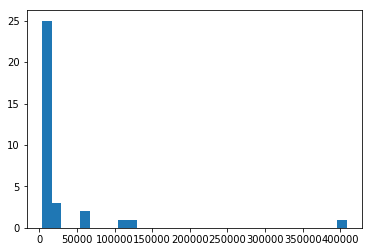

In [7]:
# 绘制占比图
plt.hist(train_df['label'].value_counts(),32)
plt.show()

In [9]:
# train_df['auditing_date'].min()：Timestamp('2018-01-01 00:00:00') \
# ——train_df['auditing_date'].max()：Timestamp('2018-12-31 00:00:00') 训练数据为2018年一年创建的相应订单数据

In [10]:
clf_labels = train_df['label'].values
amt_labels = train_df['repay_amt'].values
# del train_df['label'], train_df['repay_amt'], train_df['repay_date']
train_due_amt_df = train_df['due_amt'].values
train_num = train_df.shape[0]

In [11]:
# 读取test数据集
test_df = pd.read_csv(path+'test.csv', parse_dates=['auditing_date', 'due_date'])
sub = test_df[['listing_id', 'auditing_date', 'due_amt']]

In [12]:
# test_df['auditing_date'].min()：Timestamp('2019-02-01 00:00:00')——
#  test_df['auditing_date'].max()：Timestamp('2019-03-31 00:00:00') 测试数据为2月-3月两个月数据，！特别注意是2月为28天。

In [13]:
# 合并两数据集
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

## 获得截至日期的月，天属性
df['due_month'] = df['due_date'].dt.month
df['due_weekday'] = df['due_date'].apply(lambda x:x.isoweekday())

## 获得还款日期的天属性
df['repay_weekday'] = df['repay_date'].apply(lambda x:x.isoweekday())

In [14]:
df

,auditing_date,due_amt,due_date,label,listing_id,repay_amt,repay_date,user_id,due_month,due_weekday,repay_weekday
0,2018-04-25,72.1167,2018-05-25,0.0,3163926,72.116699,2018-05-25,748147,5,5,5.0
1,2018-06-09,258.7045,2018-07-09,1.0,3698760,258.704498,2018-07-08,672952,7,1,7.0
2,2018-02-18,307.9270,2018-03-18,-1.0,2355665,0.000000,2018-03-19,404196,3,7,1.0
3,2018-01-13,252.9809,2018-02-13,0.0,1994522,252.980896,2018-02-13,342769,2,2,2.0
4,2018-06-01,107.6503,2018-07-01,6.0,3602352,107.650299,2018-06-25,828139,7,7,1.0
5,2018-10-25,201.0499,2018-11-25,16.0,4745662,201.049896,2018-11-09,795130,11,7,5.0
6,2018-06-19,3730.9948,2018-07-19,0.0,3779424,3730.994873,2018-07-19,95223,7,4,4.0
7,2018-03-25,1040.5302,2018-04-25,0.0,2759330,1040.530151,2018-04-25,115500,4,3,3.0
8,2018-02-28,133.9311,2018-03-28,2.0,2464315,133.931107,2018-03-26,515940,3,3,1.0
9,2018-09-23,394.3774,2018-10-23,-1.0,4509276,0.000000,2018-10-24,757631,10,2,3.0


In [15]:
## 读取listing 表数据
listing_info_df = pd.read_csv(path+'listing_info.csv',parse_dates=['auditing_date'])

# Timestamp('2016-07-05 00:00:00')——Timestamp('2019-03-31 00:00:00') listing表包含大量历史订单数据。

list_count=listing_info_df['user_id'].value_counts().reset_index()
list_count.columns = ['user_id','times']
list_count

list_pricipal = listing_info_df.groupby('user_id')['principal'].\
                                agg({'mean_principal':'mean','std_principal':'std'}).reset_index()
list_pricipal = list_pricipal.fillna(0)

df = df.merge(list_pricipal,on=['user_id'],how='left')

In [16]:
listing_info_df['auditing_date_month'] = pd.to_datetime(listing_info_df['auditing_date']).dt.month
listing_info_df['auditing_date_days'] = listing_info_df['auditing_date_month'].copy()
# print(sub_example['due_date'])
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==1] = 31
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==3] = 31
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==5] = 31
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==7] = 31
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==8] = 31
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==10] = 31
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==12] = 31
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==4] = 30
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==6] = 30
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==9] = 30
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==11] = 30
listing_info_df['auditing_date_days'][listing_info_df['auditing_date_days']==2] = 28

listing_info_df['principal_per_term'] = listing_info_df['principal']/listing_info_df['term']
list_count=listing_info_df['user_id'].value_counts()
df_count_times=pd.DataFrame(list_count)
df_count_times.rename(columns={ df_count_times.columns[0]: "loan_times" },inplace=True)
df_count_times['user_id']=df_count_times.index
bin_size=(1,2,4,8)
def count_to_style(count):
    n=1
    num=1
    while count>n and num<5:
        n=n*2
        num=num+1
    return num
df_count_times['loan_times_type']=df_count_times['loan_times'].apply(count_to_style)
del df_count_times['loan_times']


list_principle=listing_info_df['principal'].value_counts()
principal_df=pd.DataFrame(list_principle)
principal_df.rename(columns={principal_df.columns[0]: "frequency"},inplace=True)
principal_df['principal']=principal_df.index
principal_df.reset_index(drop=True, inplace=True)
def ChangeToClass(principal):
    if principal<=1170:
        return 6
    elif 1170<principal<=2260:
        return 5
    elif 2260<principal<=3350:
        return 4
    elif 3350<principal<=3910:
        return 3
    elif 3910<principal<=5540:
        return 2
    else:
        return 1
principal_df['principal_class']=principal_df['principal'].apply(ChangeToClass)
del principal_df['frequency']

listing_info_df=listing_info_df.merge(principal_df, on="principal", how="left")

listing_info_df['TermRate']=listing_info_df['rate']/listing_info_df['term']

print(listing_info_df.head())
# del listing_info_df['user_id'], listing_info_df['auditing_date']
df = df.merge(listing_info_df, on=['user_id','listing_id','auditing_date'], how='left')

   user_id  listing_id auditing_date  term  rate  principal  \
0   316610     1556649    2017-11-26     9   7.6       4800   
1    62002     1556633    2017-11-26     6   7.6       4000   
2   192135     1556629    2017-11-26    12   8.0       8660   
3   487382     1556628    2017-11-26     9   7.6       4780   
4   235186     1556627    2017-11-26     9   7.6       1480   

   auditing_date_month  auditing_date_days  principal_per_term  \
0                   11                  30          533.333333   
1                   11                  30          666.666667   
2                   11                  30          721.666667   
3                   11                  30          531.111111   
4                   11                  30          164.444444   

   principal_class  TermRate  
0                2  0.844444  
1                2  1.266667  
2                1  0.666667  
3                2  0.844444  
4                5  0.844444  


In [17]:
# 表中有少数user不止一条记录，因此按日期排序，去重，只保留最新的一条记录。
user_info = pd.read_csv(path+'user_info.csv', parse_dates=['reg_mon', 'insertdate'])

user_info.rename(columns={'insertdate': 'info_insert_date'}, inplace=True)

user_info = user_info.sort_values(by='info_insert_date', ascending=False).drop_duplicates('user_id').reset_index(drop=True)

user_info['gender']=user_info['gender'].apply(lambda x:1 if x.strip()=='男' else 0)

user_info['id_city'] = user_info['id_city'].apply(lambda x: x.replace('\\N', 'c0'))
def compare(a,b):
    if a==b: return 1
    else: return 0
user_info['remote_boolean']=user_info.apply(lambda user_info:compare(user_info['cell_province'],user_info['id_province']),axis=1)

city_map=user_info.groupby('id_city').agg({'id_city':'count'})
city_map[city_map['id_city']>11000]
city_map.columns=['count']
city_map.reset_index(inplace=True)
x = city_map[city_map["count"] < 11000]; 
max_count = city_map["count"].max()
min_count = city_map["count"].min()

bin_size = int((max_count - min_count) / 5); 
def count_to_class(count): 
    return min(6, int((count - min_count) / bin_size))+1
city_map['class']=city_map['count'].apply(count_to_class)
city_map["class"][0]=0
city_map = city_map[["id_city", "class"]]
user_info=user_info.merge(city_map, on="id_city", how="left")

user_info=user_info.merge(df_count_times, on="user_id", how="left")  # 合并贷款次数到user_info里面

df = df.merge(user_info, on='user_id', how='left')

# 同上
user_tag_df = pd.read_csv(path+'user_taglist.csv', parse_dates=['insertdate'])
user_tag_df.rename(columns={'insertdate': 'tag_insert_date'}, inplace=True)
user_tag_df = user_tag_df.sort_values(by='tag_insert_date', ascending=False).drop_duplicates('user_id').reset_index(drop=True)

df = df.merge(user_tag_df, on='user_id', how='left')

In [30]:
# repay_log 表
repay_log_df = pd.read_csv(path+'user_repay_logs.csv', parse_dates=['due_date', 'repay_date'])
# Timestamp('2017-07-05 00:00:00')——Timestamp('2020-03-18 00:00:00')

# 由于题目任务只预测第一期的还款情况，因此这里只保留第一期的历史记录。当然非第一期的记录也能提取很多特征。
repay_log_df = repay_log_df[repay_log_df['order_id'] == 1].reset_index(drop=True)
repay_log_df['repay'] = repay_log_df['repay_date'].astype('str').apply(lambda x: 1 if x != '2200-01-01' else 0)
repay_log_df['early_repay_days'] = (repay_log_df['due_date'] - repay_log_df['repay_date']).dt.days
repay_log_df['early_repay_days'] = repay_log_df['early_repay_days'].apply(lambda x: x if x >= 0 else -1)

repay_log_df['due_month'] = repay_log_df['due_date'].dt.month
repay_log_df['due_day'] = repay_log_df['due_date'].dt.day
repay_log_df['due_weekday'] = repay_log_df['due_date'].apply(lambda x:x.isoweekday())
repay_log_df['repay_weekday'] = repay_log_df['repay_date'].apply(lambda x:x.isoweekday())

repay_log_df['early_month'] = repay_log_df['due_day'].apply(lambda x:1 if x<10 else 0)
repay_log_df['median_month'] = repay_log_df['due_day'].apply(lambda x:1 if 10<=x<20 else 0)
repay_log_df['last_month'] = repay_log_df['due_day'].apply(lambda x:1 if 20<=x else 0)

# # 合并 repay_log 和 listing_info
# repay_log_df = repay_log_df.merge(listing_info_df, on=['user_id','listing_id'],how='left')

In [ ]:
# 合并 repay_log 和 listing_info
repay_log_df_listing = repay_log_df.merge(listing_info_df, on=['user_id','listing_id'],how='left')

In [19]:
def mode_0(x):
    return mode(x).mode[0]


# user_id:early_repay_days
repay_log_df_1 = repay_log_df.groupby('user_id')['early_repay_days'].agg({
    'u_early_repay_days_max': 'max', 
    'u_early_repay_days_mode': mode_0, 
    'u_early_repay_days_min': 'min',
    'u_early_repay_days_mean': 'mean', 
    'u_early_repay_days_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id'],how='left')

# user_id:due_weekday
repay_log_df_1 = repay_log_df.groupby('user_id')['due_weekday'].agg({
    'u_repay_due_weekday_mode': mode_0, 
    'u_repay_due_weekday_mean': 'mean', 
    'u_repay_due_weekday_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id'],how='left')

# user_id:repay_weekday
repay_log_df_1 = repay_log_df.groupby('user_id')['repay_weekday'].agg({
    'u_repay_weekday_mean': 'mean', 
    'u_repay_weekday_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id'],how='left')

# user_id:repay
repay_log_df_1 = repay_log_df.groupby('user_id')['repay'].agg({
    'u_repay_mean': 'mean', 
    'u_repay_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id'],how='left')

In [ ]:
# user_id,due_month:repay
repay_log_df_1 = repay_log_df.groupby(['user_id','due_month'])['repay'].agg({
    'u_dm_repay_mean': 'mean', 
    'u_dm_repay_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id','due_month'],how='left')


# user_id,due_month:early_repay_days
repay_log_df_1 = repay_log_df.groupby(['user_id','due_month'])['early_repay_days'].agg({
    'u_dm_early_repay_days_mean': 'mean', 
    'u_dm_early_repay_days_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id','due_month'],how='left')


# user_id,due_weekday:repay
repay_log_df_1 = repay_log_df.groupby(['user_id','due_weekday'])['repay'].agg({
    'u_dw_repay_mean': 'mean', 
    'u_dw_repay_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id','due_weekday'],how='left')


# user_id,due_weekday:early_repay_days
repay_log_df_1 = repay_log_df.groupby(['user_id','due_weekday'])['early_repay_days'].agg({
    'u_dw_early_repay_days_mean': 'mean', 
    'u_dw_early_repay_days_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id','due_weekday'],how='left')

In [26]:
# user_id,rate:repay
repay_log_df_1 = repay_log_df_listing.groupby(['user_id','rate'])['repay'].agg({
    'u_r_repay_mean': 'mean', 
    'u_r_repay_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id','rate'],how='left')

# user_id,rate:early_repay_days
repay_log_df_1 = repay_log_df_listing.groupby(['user_id','rate'])['early_repay_days'].agg({
    'u_r_early_repay_days_mean': 'mean', 
    'u_r_early_repay_days_std': 'std'
}).reset_index()
repay_log_df_1 = repay_log_df_1.fillna(0)
repay_log_df_1

df = df.merge(repay_log_df_1,on=['user_id','rate'],how='left')

# # user_id,repay_amt:repay
# repay_log_df_1 = repay_log_df.groupby(['user_id','repay_amt'])['repay'].agg({
#     'u_ra_repay_mean': 'mean', 
#     'u_ra_repay_std': 'std'
# }).reset_index()
# repay_log_df_1 = repay_log_df_1.fillna(0)
# repay_log_df_1

# df = df.merge(repay_log_df_1,on=['user_id','repay_amt'],how='left')

# # user_id,repay_amt:early_repay_days
# repay_log_df_1 = repay_log_df.groupby(['user_id','repay_amt'])['early_repay_days'].agg({
#     'u_ra_early_repay_days_mean': 'mean', 
#     'u_ra_early_repay_days_std': 'std'
# }).reset_index()
# repay_log_df_1 = repay_log_df_1.fillna(0)
# repay_log_df_1

# df = df.merge(repay_log_df_1,on=['user_id','repay_amt'],how='left')

In [31]:
## 区分不同频次的用户
old_user_list = list(repay_log_df['user_id'])

user_id_freq = pd.DataFrame(repay_log_df['user_id'].value_counts()).reset_index()
user_id_freq.columns = ['user_id','freq']
user_id_freq


def percent_75(df):
    return np.percentile(df,75)

def percent_25(df):
    return np.percentile(df,25)

freq_75 = percent_75(user_id_freq['freq'].values)
freq_25 = percent_25(user_id_freq['freq'].values)

user_id_freq['most_freq'] = user_id_freq['freq'].apply(lambda x: 1 if x>=freq_75 else 0)
user_id_freq['median_freq'] = user_id_freq['freq'].apply(lambda x: 1 if freq_25<=x<freq_75 else 0 )
user_id_freq['lower_freq'] = user_id_freq['freq'].apply(lambda x: 1 if x<freq_25 else 0 )
user_id_freq

repay_log_df = repay_log_df.merge(user_id_freq,on=['user_id'],how='left')

df = df.merge(user_id_freq,on=['user_id'],how='left')

df['freq_early_repay_days_mean'] = 0
df['freq_early_repay_days_std'] = 0

In [34]:
repay_log_df

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt,repay,early_repay_days,due_month,due_day,due_weekday,repay_weekday,early_month,median_month,last_month,freq,most_freq,median_freq,lower_freq
0,748483,1858122,1,2018-01-29,528.6365,2018-01-28,528.6365,1,1,1,29,1,7,0,0,1,4,0,1,0
1,369368,3900565,1,2018-08-03,385.5078,2018-07-22,385.5078,1,12,8,3,5,7,1,0,0,3,0,1,0
2,749102,1699160,1,2018-01-11,338.5357,2017-12-11,338.5357,1,31,1,11,4,1,0,1,0,1,0,1,0
3,385257,2204015,1,2018-03-03,1106.1967,2018-03-02,1106.1967,1,1,3,3,6,5,1,0,0,5,1,0,0
4,648677,3811960,1,2018-07-23,385.5078,2018-07-04,385.5078,1,19,7,23,1,3,0,0,1,28,1,0,0
5,46421,3493073,1,2018-06-22,423.7665,2018-06-21,423.7665,1,1,6,22,5,4,0,0,1,11,1,0,0
6,237430,4058618,1,2018-08-23,212.5250,2200-01-01,212.5250,0,-1,8,23,4,3,0,0,1,8,1,0,0
7,391438,3266118,1,2018-06-03,385.8409,2018-06-03,385.8409,1,0,6,3,7,7,1,0,0,10,1,0,0
8,289893,1114293,1,2017-11-06,1020.1285,2017-11-06,1020.1285,1,0,11,6,1,1,1,0,0,4,0,1,0
9,106403,1152391,1,2017-11-10,425.6166,2017-11-10,425.6166,1,0,11,10,5,5,0,1,0,9,1,0,0


In [35]:
# 不同频率层次打标
most_fre_mean = repay_log_df[repay_log_df['most_freq']==1]['early_repay_days'].mean()
most_fre_var = repay_log_df[repay_log_df['most_freq']==1]['early_repay_days'].var()

median_fre_mean = repay_log_df[repay_log_df['median_freq']==1]['early_repay_days'].mean()
median_fre_var = repay_log_df[repay_log_df['median_freq']==1]['early_repay_days'].var()

lower_fre_mean = repay_log_df[repay_log_df['lower_freq']==1]['early_repay_days'].mean()
lower_fre_var = repay_log_df[repay_log_df['lower_freq']==1]['early_repay_days'].var()

df['freq_early_repay_days_mean'].loc[df['most_freq']==1] = most_fre_mean
df['freq_early_repay_days_mean'].loc[df['median_freq']==1] = median_fre_mean
df['freq_early_repay_days_mean'].loc[df['lower_freq']==1] = lower_fre_mean

df['freq_early_repay_days_std'].loc[df['most_freq']==1] = most_fre_var
df['freq_early_repay_days_std'].loc[df['median_freq']==1] = median_fre_var
df['freq_early_repay_days_std'].loc[df['lower_freq']==1] = lower_fre_var

In [36]:
df

,auditing_date,due_amt,due_date,label,listing_id,repay_amt,repay_date,user_id,due_month,due_weekday,repay_weekday,mean_principal,std_principal,term,rate,principal,auditing_date_month,auditing_date_days,principal_per_term,principal_class,TermRate,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,remote_boolean,class,loan_times_type,taglist,tag_insert_date,u_early_repay_days_max,u_early_repay_days_mode,u_early_repay_days_min,u_early_repay_days_mean,u_early_repay_days_std,u_repay_due_weekday_mode,u_repay_due_weekday_mean,u_repay_due_weekday_std,u_repay_weekday_mean,u_repay_weekday_std,u_repay_mean,u_repay_std,u_dm_repay_mean,u_dm_repay_std,u_dm_early_repay_days_mean,u_dm_early_repay_days_std,u_dw_repay_mean,u_dw_repay_std,u_dw_early_repay_days_mean,u_dw_early_repay_days_std,u_r_repay_mean,u_r_repay_std,u_r_early_repay_days_mean,u_r_early_repay_days_std,u_ra_repay_mean,u_ra_repay_std,u_ra_early_repay_days_mean,u_ra_early_repay_days_std,freq_x,most_freq_x,median_freq_x,lower_freq_x,freq_early_repay_days_mean,freq_early_repay_days_std,freq_y,most_freq_y,median_freq_y,lower_freq_y,freq,most_freq,median_freq,lower_freq
0,2018-04-25,72.1167,2018-05-25,0.0,3163926,72.116699,2018-05-25,748147,5,5,5.0,1062.000000,451.796414,9,7.2,630,4,30,70.000000,6,0.800000,2017-12-01,1,21,c20,c20,c20089,2018-04-24,1,2,4,127|5539|5556|1749|1100|239|1803|1911|2519|351...,2018-11-12,28.0,0.0,0.0,9.333333,16.165808,2.0,4.333333,2.081666,4.333333,2.081666,1.000000,0.000000,1.0,0.0,14.0,19.79899,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,3.0,0.0,1.0,0.0,4.440400,64.752063,3.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0
1,2018-06-09,258.7045,2018-07-09,1.0,3698760,258.704498,2018-07-08,672952,7,1,7.0,2097.000000,1314.348592,9,7.2,2260,6,30,251.111111,5,0.800000,2017-09-01,1,37,c14,c17,c17250,2018-06-04,0,2,5,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,12.0,1.0,0.0,3.200000,4.969909,6.0,4.600000,2.509980,4.200000,1.923538,1.000000,0.000000,NaN,NaN,NaN,NaN,1.0,0.0,12.0,0.000000,1.000000,0.000000,4.000000,5.354126,NaN,NaN,NaN,NaN,5.0,1.0,0.0,0.0,5.235432,69.286297,5.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0
2,2018-02-18,307.9270,2018-03-18,-1.0,2355665,0.000000,2018-03-19,404196,3,7,1.0,2183.333333,877.572409,9,7.2,2690,2,28,298.888889,4,0.800000,2017-02-01,1,24,c04,c04,c04251,2018-02-17,1,3,3,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,24.0,-1.0,-1.0,11.500000,17.677670,3.0,4.000000,1.414214,5.000000,2.828427,0.500000,0.707107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,24.000000,0.000000,NaN,NaN,NaN,NaN,2.0,0.0,1.0,0.0,4.440400,64.752063,2.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0
3,2018-01-13,252.9809,2018-02-13,0.0,1994522,252.980896,2018-02-13,342769,2,2,2.0,3258.571429,1309.114568,9,7.2,2210,1,31,245.555556,5,0.800000,2016-12-01,1,23,c17,c17,c17246,2018-01-12,1,2,4,1100|472|3422|3296|4949|4025|3328|974|4092|218...,2018-01-12,4.0,1.0,1.0,2.000000,1.732051,1.0,4.333333,3.055050,4.666667,2.081666,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,1.0,0.0,4.440400,64.752063,3.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0
4,2018-06-01,107.6503,2018-07-01,6.0,3602352,107.650299,2018-06-25,828139,7,7,1.0,1170.000000,763.675324,6,8.6,630,6,30,105.000000,6,1.433333,2018-04-01,1,23,c02,c17,c17096,2018-05-31,0,2,2,5784|3643|2017|3432|469|5151|1625|1753|2762|15...,2018-05-31,0.0,0.0,0.0,0.000000,0.000000,5.0,5.000000,0.000000,5.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,4.440400,64.752063,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,2018-10-25,201.0499,2018-11-25,16.0,4745662,201.049896,2018-11-09,795130,11,7,5.0,2575.714286,1952.817257,6,7.6,1180,10,31,196.666667,5,1.266667,2018-02-01,1,31,c31,c31,c31067,2018-12-30,1,2,4,631|5784|948|3898|3864|4173|2017|5376|727|2365...,2018-12-30,26.0,9.0,9.0,16.800000,7.190271,5.0,5.000000,1.414214,5.000000,1.581139,1.000000,0.000000,1.0,0.0,16.0,0.00000,1.0,0.0,16.0,0.000000,1.000000,0.000000,13.5000

In [ ]:
## 获得截至日期的月，天属性
df['reg_mon_y'] = df['reg_mon'].dt.year
df['reg_mon_m'] = df['reg_mon'].dt.month

In [2]:
def obtain_x2(train_df,xtype):
    dtype_df = train_df.dtypes.reset_index()
    dtype_df.columns = ['col','type']
    return dtype_df[dtype_df.type==xtype].col.values

In [ ]:
object_col = obtain_x2(df,'object') #float64
object_col

In [1]:
datetime_col = obtain_x2(df,'datetime') #float64
datetime_col

NameError: name 'obtain_x2' is not defined

In [ ]:
del df[object_col]
del df[datetime_col]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130000 entries, 0 to 1129999
Data columns (total 75 columns):
auditing_date                 1130000 non-null datetime64[ns]
due_amt                       1130000 non-null float64
due_date                      1130000 non-null datetime64[ns]
label                         1000000 non-null float64
listing_id                    1130000 non-null int64
repay_amt                     1000000 non-null float32
repay_date                    1000000 non-null datetime64[ns]
user_id                       1130000 non-null int64
due_month                     1130000 non-null int64
due_weekday                   1130000 non-null int64
repay_weekday                 1000000 non-null float64
mean_principal                1130000 non-null float64
std_principal                 1130000 non-null float64
term                          1130000 non-null int64
rate                          1130000 non-null float64
principal                     1130000 non-null int6

In [ ]:
############
## Train
############

train_values, test_values = df[:train_num].values, df[train_num:].values
# 五折验证也可以改成一次验证，按时间划分训练集和验证集，以避免由于时序引起的数据穿越问题。
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'metric_freq': 5,
    'num_class': 33,
    'num_iterations': 600,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'device_type':'gpu'
}
amt_oof = np.zeros(train_num)
prob_oof = np.zeros((train_num, 33))
test_pred_prob = np.zeros((test_values.shape[0], 33))


for i, (trn_idx, val_idx) in enumerate(skf.split(train_values, clf_labels)):
    print(i, 'fold...')
    t = time.time()
    trn_x, trn_y = train_values[trn_idx], clf_labels[trn_idx]
    val_x, val_y = train_values[val_idx], clf_labels[val_idx]
    val_repay_amt = amt_labels[val_idx]
    val_due_amt = train_due_amt_df.iloc[val_idx]
   
    train = lgb.Dataset(trn_x, label=trn_y)
    val = lgb.Dataset(val_x, label=val_y, reference=train)
    gbm = lgb.train(params, train, valid_sets=val, early_stopping_rounds=10)

    # shepe = (-1, 33)
    val_pred_prob_everyday = gbm.predict(val_x, num_iteration=gbm.best_iteration)
    prob_oof[val_idx] = val_pred_prob_everyday
    val_pred_prob_today = [val_pred_prob_everyday[i][val_y[i]] for i in range(val_pred_prob_everyday.shape[0])]
    val_pred_repay_amt = val_due_amt['due_amt'].values * val_pred_prob_today
    print('val rmse:', np.sqrt(mean_squared_error(val_repay_amt, val_pred_repay_amt)))
    print('val mae:', mean_absolute_error(val_repay_amt, val_pred_repay_amt))
    amt_oof[val_idx] = val_pred_repay_amt
    test_pred_prob += gbm.predict(test_values, num_iteration=gbm.best_iteration) / skf.n_splits
    print('runtime: {}\n'.format(time.time() - t))

print('\ncv rmse:', np.sqrt(mean_squared_error(amt_labels, amt_oof)))
print('cv mae:', mean_absolute_error(amt_labels, amt_oof))
print('cv logloss:', log_loss(clf_labels, prob_oof))
print('cv acc:', accuracy_score(clf_labels, np.argmax(prob_oof, axis=1)))


In [ ]:
prob_cols = ['prob_{}'.format(i) for i in range(33)]

for i, f in enumerate(prob_cols):
    sub[f] = test_pred_prob[:, i]

sub_example = pd.read_csv(path+'submission.csv', parse_dates=['repay_date'])

sub_example = sub_example.merge(sub, on='listing_id', how='left')
# sub_example['due_date'] = pd.to_datetime((sub_example['auditing_date'] + np.timedelta64(1, 'M') + np.timedelta64(1, 'D')).dt.date)

sub_example['due_date'] = sub_example['auditing_date'].copy()
# print(sub_example['due_date'])
sub_example['due_date'][sub_example['due_date'].dt.month == 4] = pd.to_datetime((sub_example['due_date'][sub_example['due_date'].dt.month == 4] + np.timedelta64(1, 'M')).dt.date)
sub_example['due_date'][sub_example['due_date'].dt.month == 3] = pd.to_datetime((sub_example['due_date'][sub_example['due_date'].dt.month == 3] + np.timedelta64(1, 'M') + np.timedelta64(1, 'D')).dt.date)
sub_example['due_date'][sub_example['due_date'].dt.month == 2] = pd.to_datetime((sub_example['due_date'][sub_example['due_date'].dt.month == 2] + np.timedelta64(1, 'M') - np.timedelta64(2, 'D')).dt.date)

sub_example['days'] = (sub_example['due_date'] - sub_example['repay_date']).dt.days

# shape = (-1, 33)
test_prob = sub_example[prob_cols].values
test_labels = sub_example['days'].values
test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]
sub_example['repay_amt'] = sub_example['due_amt'] * test_prob
sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv('sub_cross_5_end.csv', index=False)